# Setup

In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
# Working directories
current_dir = os.getcwd()
print("Notebooks directory:", current_dir)
parent_dir = os.path.dirname(current_dir)
print("Local working directory:", parent_dir)
data_dir = parent_dir+"/data/"
print("Data directory:", data_dir)

Notebooks directory: d:\WQU\CAPSTONE\WQU-Capstone\notebooks
Local working directory: d:\WQU\CAPSTONE\WQU-Capstone
Data directory: d:\WQU\CAPSTONE\WQU-Capstone/data/


# Import Data

In [4]:


pkl_data = data_dir + "etf_data_with_indicators.pkl"
etf_data = pd.read_pickle(pkl_data)


In [5]:
# Check the shape of the data
print(f"Number of ETFs: {len(etf_data)}")
print(f"Sample ETF data shape: {next(iter(etf_data.values())).shape}")

Number of ETFs: 75
Sample ETF data shape: (1761, 23)


In [6]:
# Create a combined dataframe with all ETFs' closing prices
etf_keys = list(etf_data.keys())
close_prices = pd.DataFrame()

In [7]:
# Extract closing prices for all ETFs
for ticker in etf_keys:
    if 'adjClose' in etf_data[ticker].columns:
        close_prices[ticker] = etf_data[ticker]['adjClose']

In [8]:
# Handle missing values
close_prices = close_prices.dropna(axis=0, how='any')
print(f"Price data shape after dropping NAs: {close_prices.shape}")

Price data shape after dropping NAs: (1760, 75)


In [9]:
# Calculate returns for PCA
returns = close_prices.pct_change().dropna()
print(f"Returns data shape: {returns.shape}")

Returns data shape: (1759, 75)


In [10]:
# Apply StandardScaler to returns
scaler = StandardScaler()
scaled_returns = pd.DataFrame(
    scaler.fit_transform(returns),
    index=returns.index,
    columns=returns.columns
)
# Transpose the scaled returns for PCA
scaled_returns = scaled_returns.T

# Applying PCA

In [21]:
# Setting components to 5
n_components = 6
pca = PCA(n_components=n_components, random_state=42)
principal_components = pca.fit_transform(scaled_returns)

In [22]:
# Analyze explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

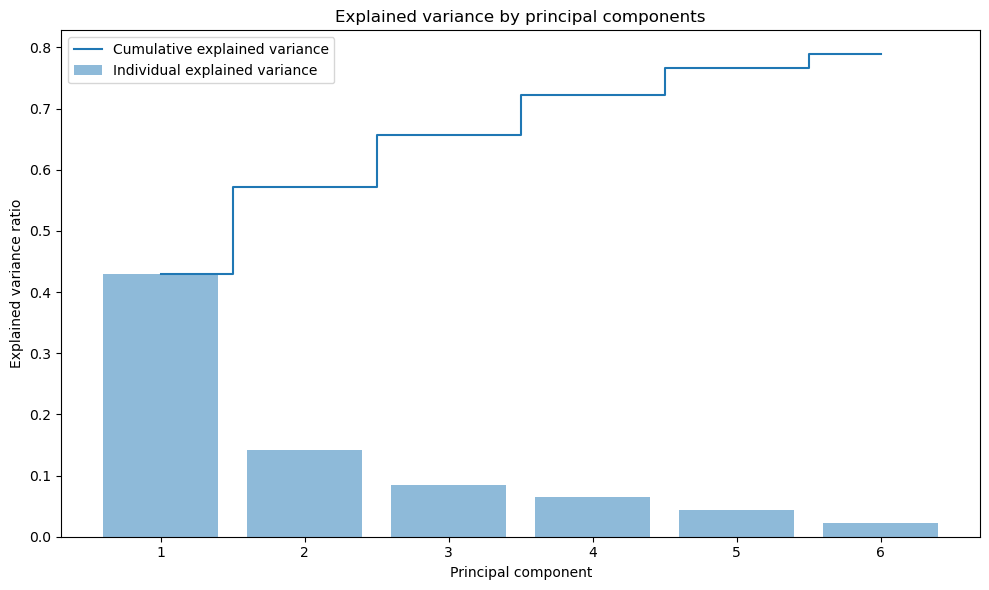

In [23]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.title('Explained variance by principal components')
plt.tight_layout()
plt.show()

# Applying OPTICS

In [28]:
#clustering on the principal components
optics_clustering = OPTICS(
    min_samples=2,           # Reduce from default (usually 5)
    max_eps=2.0,             # Increase max_eps
    metric='euclidean',
    cluster_method='xi',     # Try 'xi' method
    xi=0.05                  # Lower xi value makes it easier to form clusters
)
cluster_labels = optics_clustering.fit_predict(principal_components)

In [29]:
# Convert to pandas Series for easier handling
indices = scaled_returns.index  # Use the index of scaled_returns, which matches principal_components
clustered_series = pd.Series(cluster_labels, index=indices)
# Count ETFs per cluster
cluster_counts = pd.Series(clustered_series[clustered_series != -1].value_counts()).sort_index()
print(f"Clusters discovered: {len(cluster_counts)}")
print(f"Average cluster size: {np.mean(cluster_counts)}")
print(cluster_counts)

Clusters discovered: 12
Average cluster size: 2.0833333333333335
0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     3
10    2
11    2
Name: count, dtype: int64


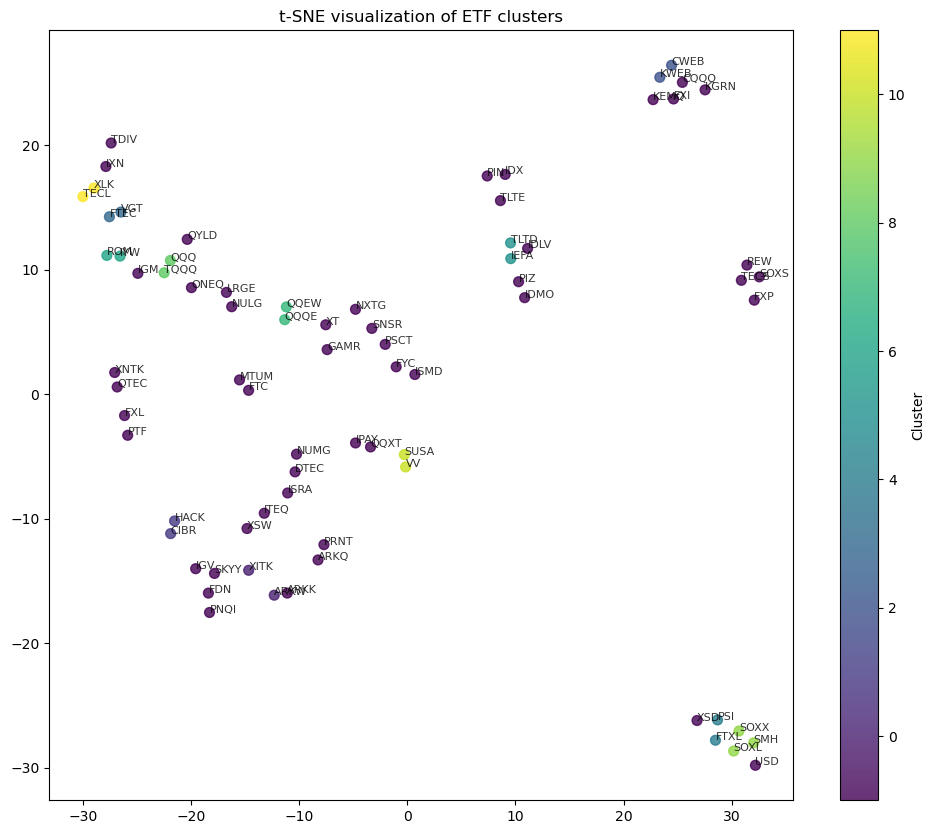


Cluster 0:
Number of ETFs: 2
Tickers: ARKW, XITK

Cluster 1:
Number of ETFs: 2
Tickers: CIBR, HACK

Cluster 2:
Number of ETFs: 2
Tickers: CWEB, KWEB

Cluster 3:
Number of ETFs: 2
Tickers: FTEC, VGT

Cluster 4:
Number of ETFs: 2
Tickers: FTXL, PSI

Cluster 5:
Number of ETFs: 2
Tickers: IEFA, TLTD

Cluster 6:
Number of ETFs: 2
Tickers: IYW, ROM

Cluster 7:
Number of ETFs: 2
Tickers: QQEW, QQQE

Cluster 8:
Number of ETFs: 2
Tickers: QQQ, TQQQ

Cluster 9:
Number of ETFs: 3
Tickers: SMH, SOXL, SOXX

Cluster 10:
Number of ETFs: 2
Tickers: SUSA, VV

Cluster 11:
Number of ETFs: 2
Tickers: TECL, XLK


In [30]:

unique_clusters = sorted(set([label for label in cluster_labels if label != -1]))

# Create a mapping from original labels to new sequential labels starting from 0
cluster_mapping = {-1: -1}  # Keep noise points as -1
for i, cluster_id in enumerate(unique_clusters):
    cluster_mapping[cluster_id] = i

# Apply the mapping to get new cluster labels
remapped_labels = np.array([cluster_mapping[label] for label in cluster_labels])

# Use remapped_labels for visualization instead of cluster_labels
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=remapped_labels, cmap='viridis', 
                     alpha=0.8, s=50)
plt.colorbar(scatter, label='Cluster')

# Add ticker labels
for i, ticker in enumerate(close_prices.columns):
    plt.annotate(ticker, (tsne_results[i, 0], tsne_results[i, 1]), 
                fontsize=8, alpha=0.8)

plt.title('t-SNE visualization of ETF clusters')
plt.savefig('tsne_etf_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Also use remapped_labels for the cluster analysis section
for cluster_id in sorted(set(remapped_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get tickers in this cluster
    mask = remapped_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    print(f"\nCluster {cluster_id}:")
    print(f"Number of ETFs: {len(tickers_in_cluster)}")
    print(f"Tickers: {', '.join(tickers_in_cluster)}")
    
    # Plot the normalized price series for this cluster
    

In [31]:
# Analyze noise points (if any)
noise_mask = remapped_labels == -1
noise_tickers = close_prices.columns[noise_mask]
if len(noise_tickers) > 0:
    print("\nNoise points (outliers):")
    print(f"Number of ETFs: {len(noise_tickers)}")
    print(f"Tickers: {', '.join(noise_tickers)}")


Noise points (outliers):
Number of ETFs: 50
Tickers: ARKK, ARKQ, CQQQ, DTEC, FDN, FTC, FXI, FXL, FXP, FYC, GAMR, IDLV, IDMO, IDX, IGM, IGV, IPAY, ISMD, ISRA, ITEQ, IXN, KEMQ, KGRN, LRGE, MTUM, NULG, NUMG, NXTG, ONEQ, PIN, PIZ, PNQI, PRNT, PSCT, PTF, QQXT, QTEC, QYLD, REW, SKYY, SNSR, SOXS, TDIV, TECS, TLTE, USD, XNTK, XSD, XSW, XT


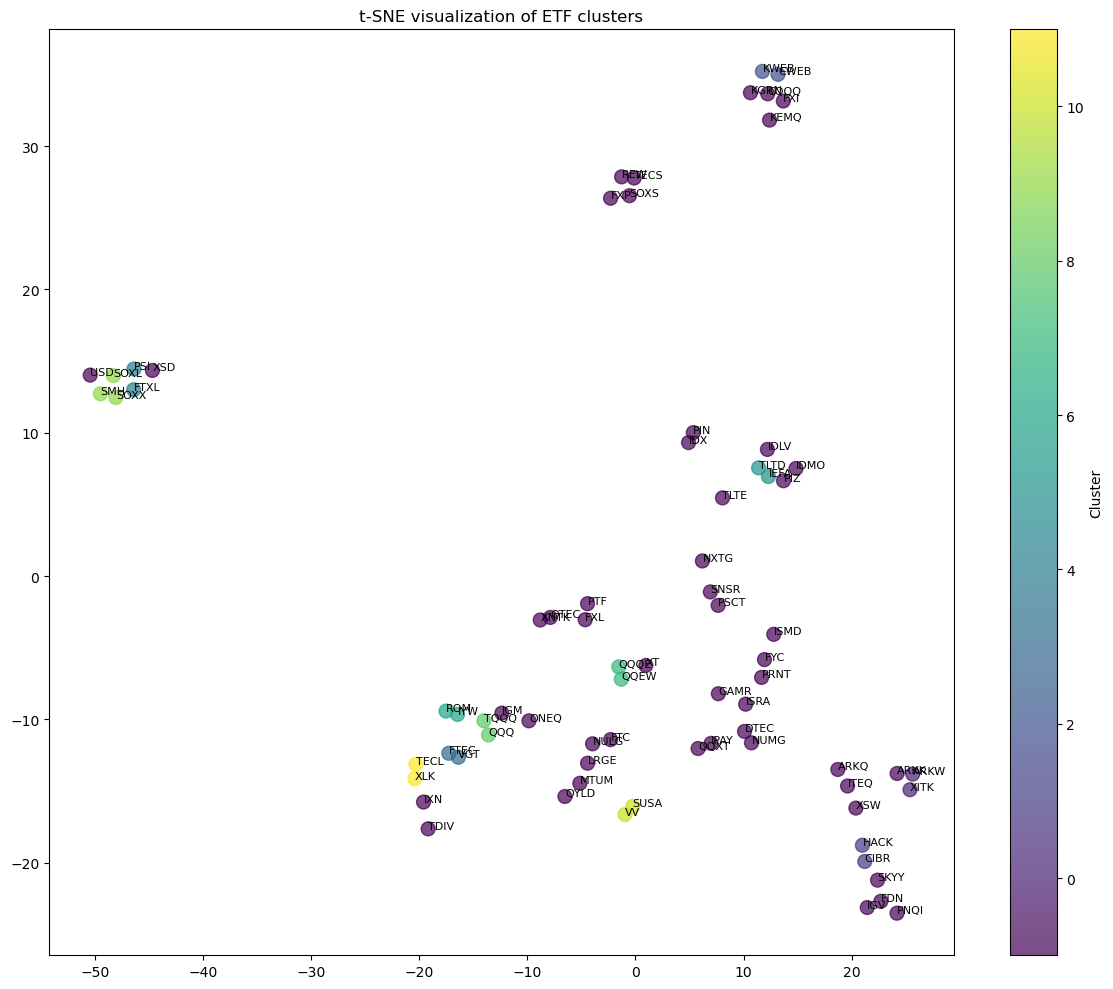

In [32]:
# Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(principal_components)

# Plot t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=100)
plt.colorbar(scatter, label='Cluster')
# Add ticker labels
for i, ticker in enumerate(close_prices.columns):
    plt.annotate(ticker, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)

plt.title('t-SNE visualization of ETF clusters')
plt.tight_layout()
plt.savefig('PCA_OPTICS_clusters_tsne.png', dpi=150)
plt.show()


Cluster 0:
Number of ETFs: 2
Tickers: ARKW, XITK


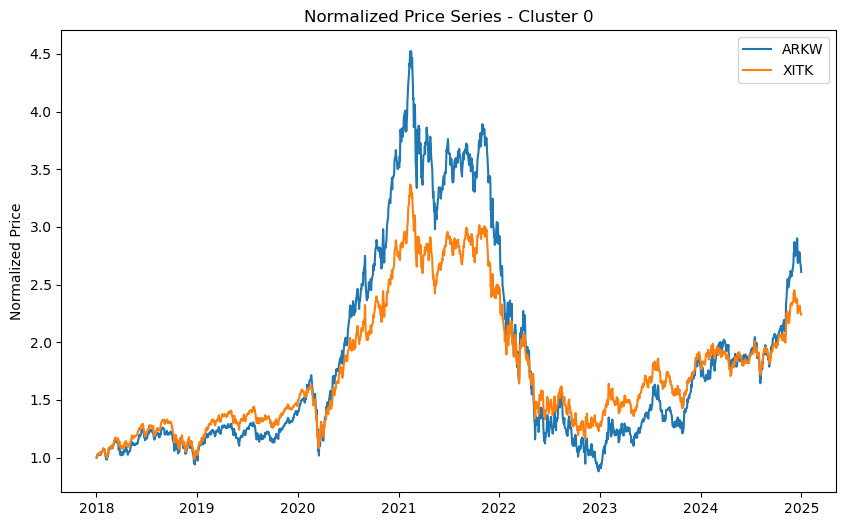


Cluster 1:
Number of ETFs: 2
Tickers: CIBR, HACK


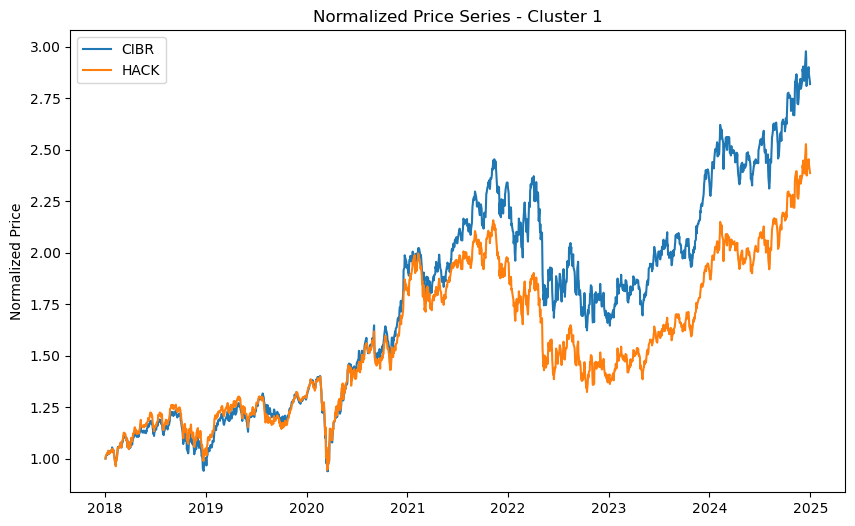


Cluster 2:
Number of ETFs: 2
Tickers: CWEB, KWEB


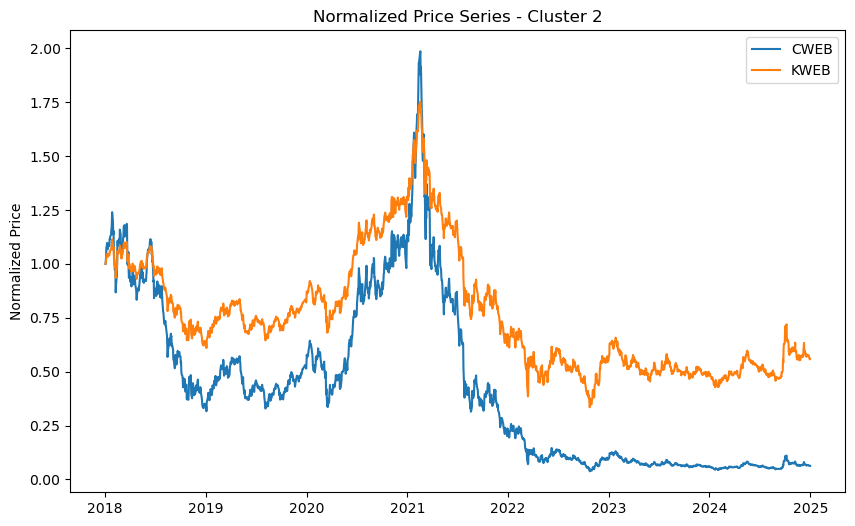


Cluster 3:
Number of ETFs: 2
Tickers: FTEC, VGT


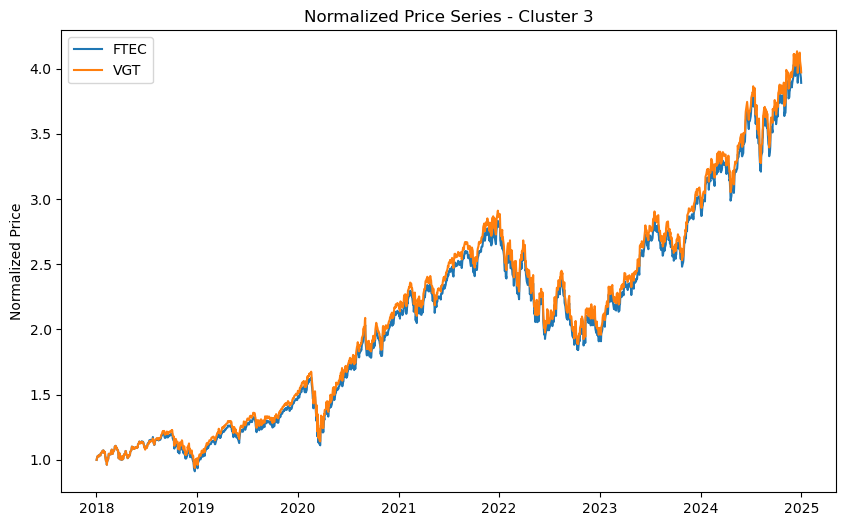


Cluster 4:
Number of ETFs: 2
Tickers: FTXL, PSI


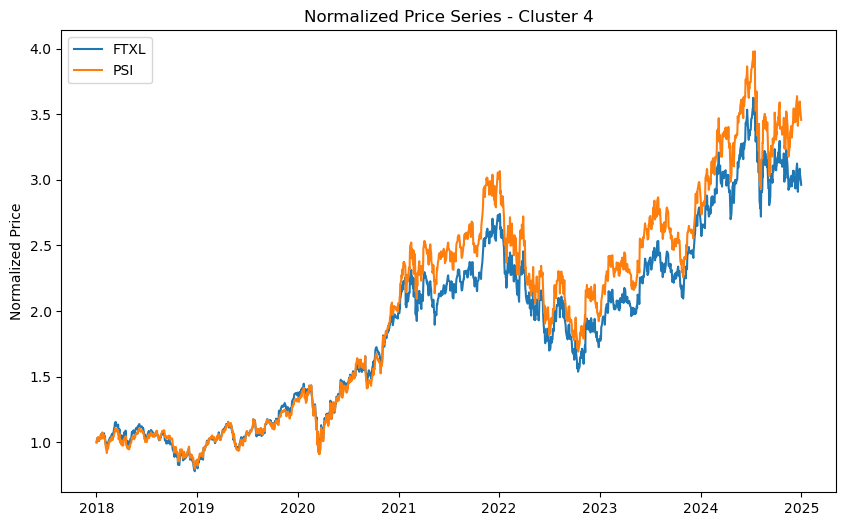


Cluster 5:
Number of ETFs: 2
Tickers: IEFA, TLTD


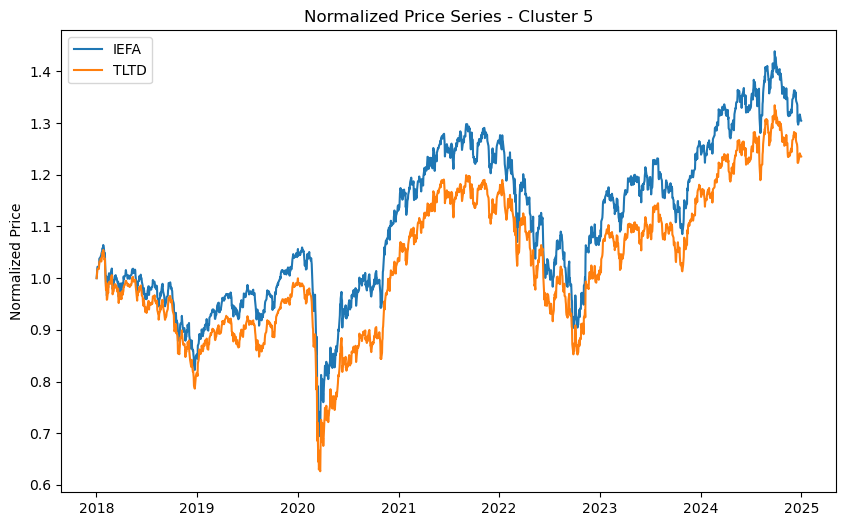


Cluster 6:
Number of ETFs: 2
Tickers: IYW, ROM


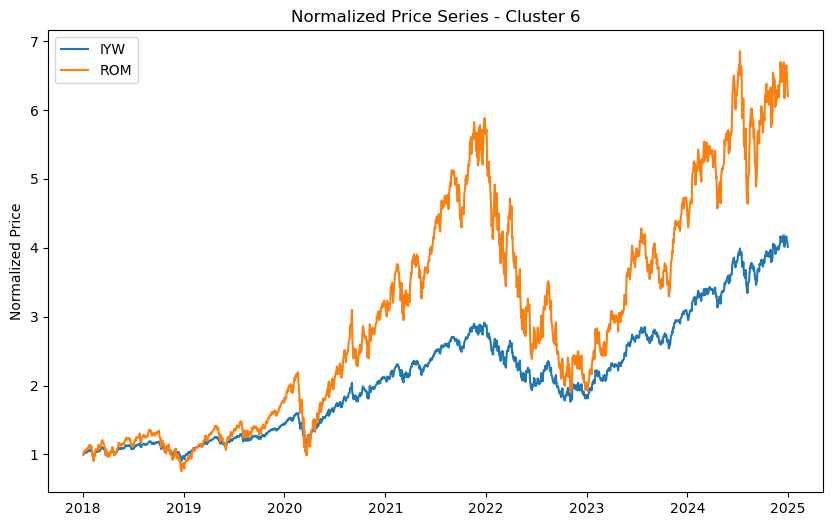


Cluster 7:
Number of ETFs: 2
Tickers: QQEW, QQQE


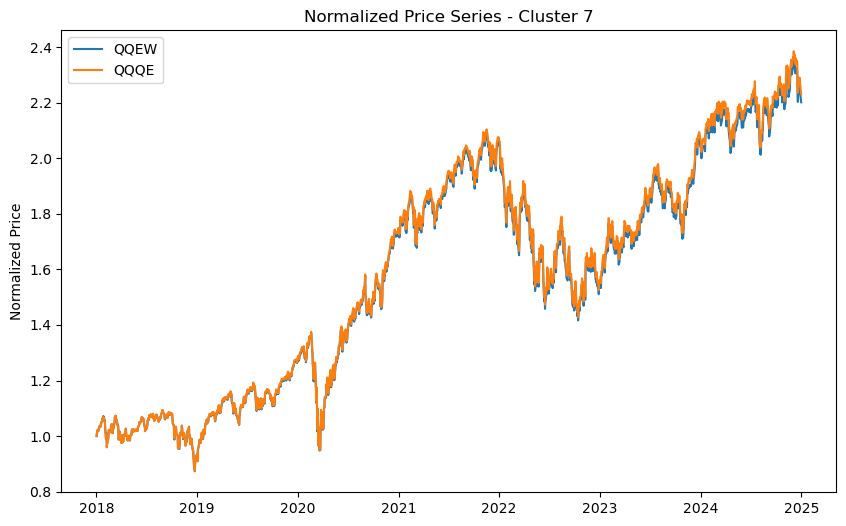


Cluster 8:
Number of ETFs: 2
Tickers: QQQ, TQQQ


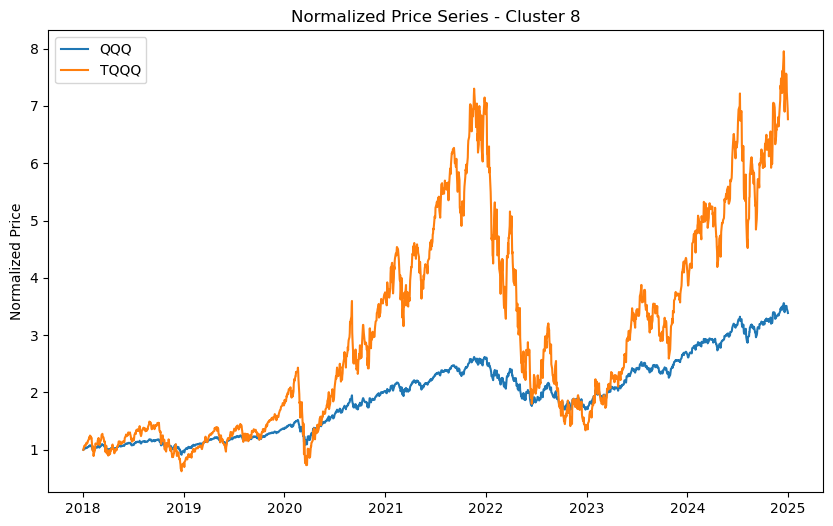


Cluster 9:
Number of ETFs: 3
Tickers: SMH, SOXL, SOXX


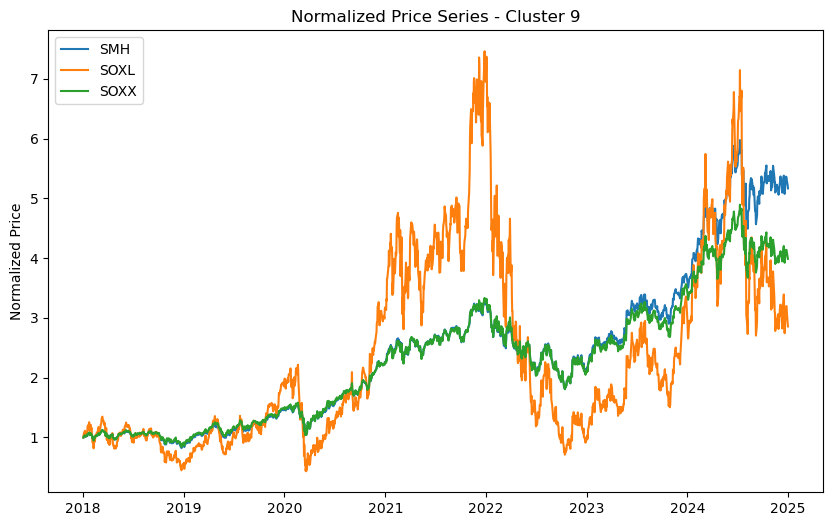


Cluster 10:
Number of ETFs: 2
Tickers: SUSA, VV


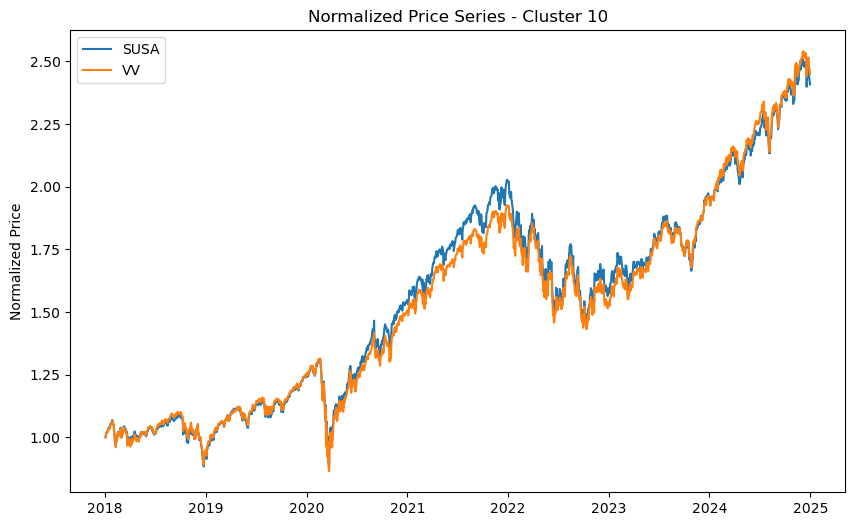


Cluster 11:
Number of ETFs: 2
Tickers: TECL, XLK


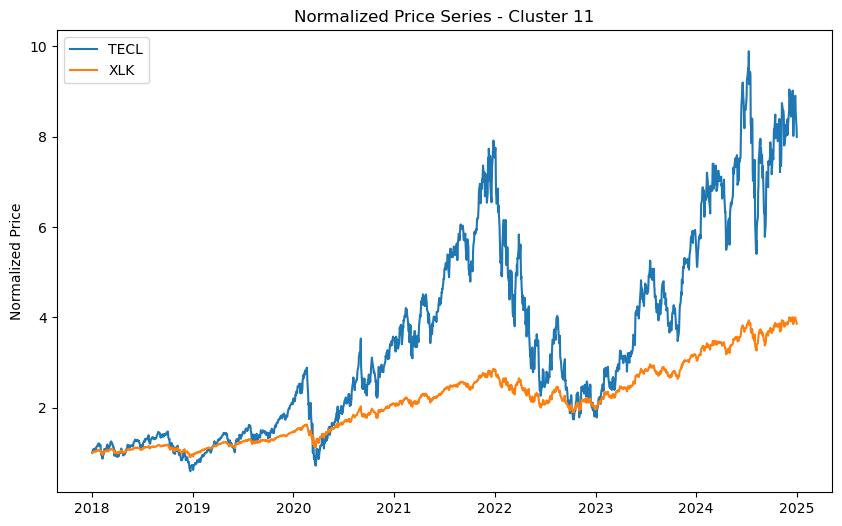

In [33]:
# Analyze clusters
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get tickers in this cluster
    mask = cluster_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    print(f"\nCluster {cluster_id}:")
    print(f"Number of ETFs: {len(tickers_in_cluster)}")
    print(f"Tickers: {', '.join(tickers_in_cluster)}")
    
    # Plot the normalized price series for this cluster
    plt.figure(figsize=(10, 6))
    for ticker in tickers_in_cluster:
        # Normalize to start at 1
        normalized_prices = close_prices[ticker] / close_prices[ticker].iloc[0]
        plt.plot(normalized_prices, label=ticker)
    
    plt.title(f'Normalized Price Series - Cluster {cluster_id}')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.savefig(f'cluster_{cluster_id}_prices.png', dpi=300, bbox_inches='tight')
    plt.show()

In [34]:
clustered_series.value_counts()


-1     50
 9      3
 0      2
 1      2
 2      2
 3      2
 4      2
 5      2
 6      2
 7      2
 8      2
 10     2
 11     2
Name: count, dtype: int64

c:\Users\steph\miniconda3\envs\wqu\Lib\site-packages\sklearn\cluster\_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
c:\Users\steph\miniconda3\envs\wqu\Lib\site-packages\sklearn\cluster\_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
c:\Users\steph\miniconda3\envs\wqu\Lib\site-packages\sklearn\cluster\_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
c:\Users\steph\miniconda3\envs\wqu\Lib\site-packages\sklearn\cluster\_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
c:\Users\steph\miniconda3\envs\wqu\Lib\site-packages\sklearn\cluster\_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all d

Top 10 parameter combinations with lowest noise percentage:


min_samples  max_eps    xi cluster_method  n_clusters  n_noise  \
20            2      inf  0.01             xi          23       10   
21            2      inf  0.05             xi          22       12   
23            2      inf  0.10             xi          20       17   
95            5      inf  0.01             xi           5       21   
17            2      5.0  0.05         dbscan          13       23   
24            2      inf  0.20             xi          18       24   
15            2      5.0  0.01             xi          20       27   
16            2      5.0  0.05             xi          20       27   
18            2      5.0  0.10             xi          20       27   
96            5      inf  0.05             xi           5       30   

    noise_percentage  avg_cluster_size  min_cluster_size  max_cluster_size  
20         13.333333          2.826087                 2                 6  
21         16.000000          2.863636                 2                 6  
23         22.666667          2.900000                 2                 6  
95         28.000000         10.800000                 6                25  
17         30.666667          4.000000                 2                18  
24         32.000000          2.833333                 2                 6  
15         36.000000          2.400000                 2                 4  
16         36.000000          2.400000                 2                 4  
18         36.000000          2.400000                 2                 4  
96         40.000000          9.000000                 6                17

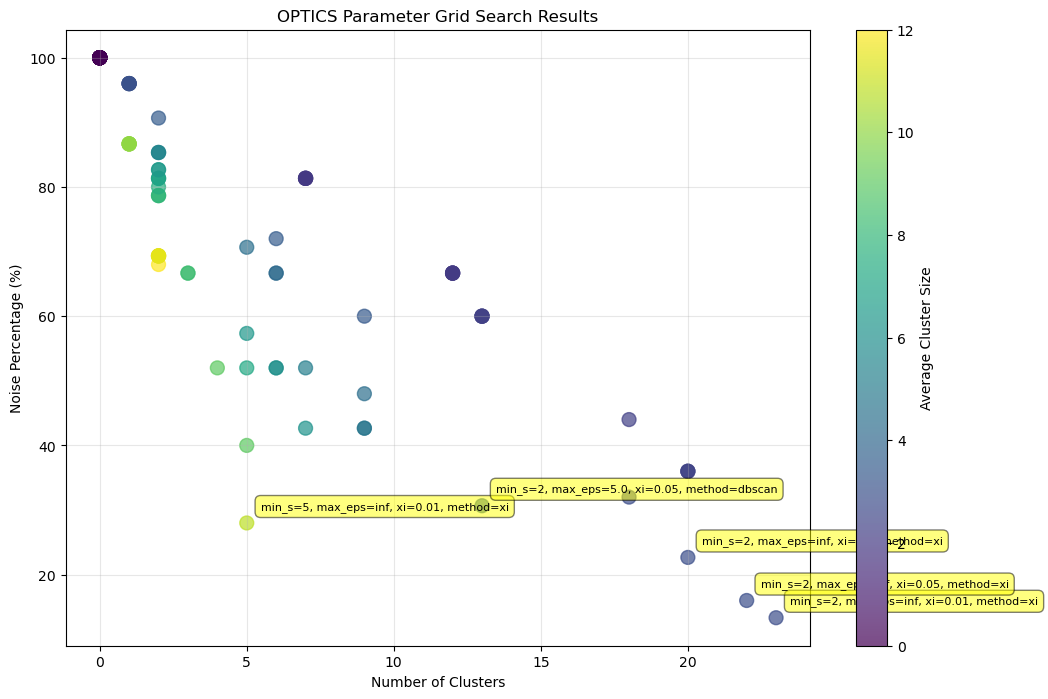


Best parameter combination:
min_samples: 2
max_eps: inf
xi: 0.01
cluster_method: xi
Number of clusters: 23
Noise percentage: 13.33%
Average cluster size: 2.83

Cluster distribution with best parameters:
-1     10
 0      3
 1      2
 2      2
 3      3
 4      3
 5      2
 6      2
 7      3
 8      3
 9      2
 10     2
 11     3
 12     3
 13     2
 14     2
 15     2
 16     3
 17     5
 18     3
 19     3
 20     6
 21     2
 22     4
Name: count, dtype: int64


c:\Users\steph\miniconda3\envs\wqu\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


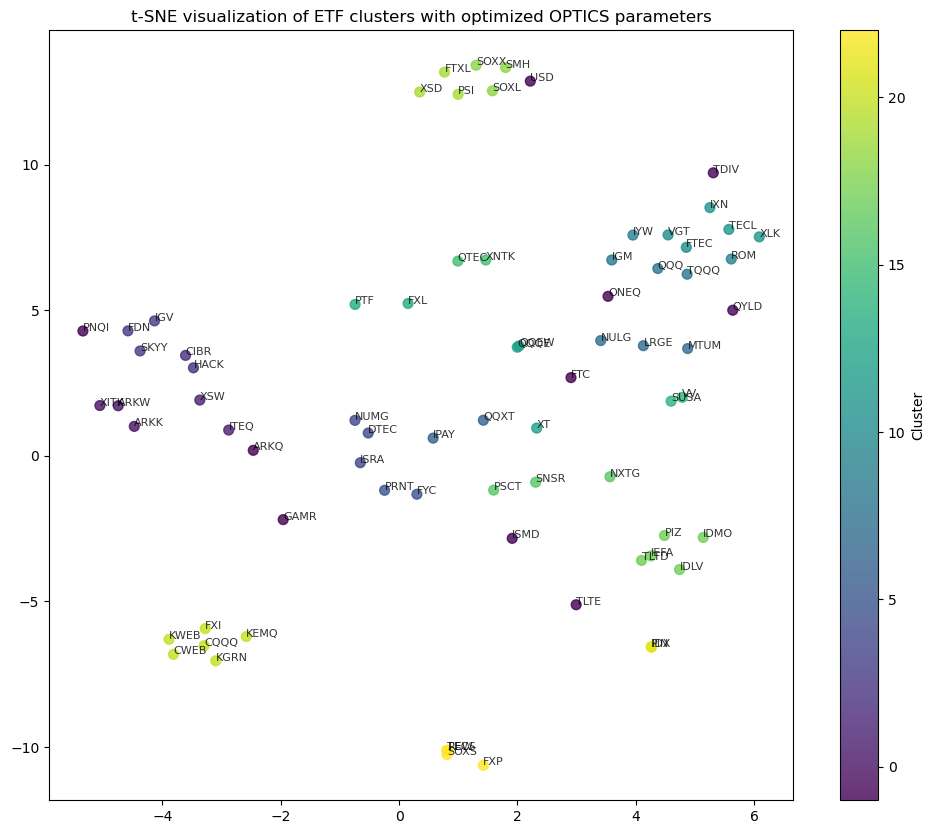

In [37]:
# Grid search for OPTICS parameters to reduce noise points
from sklearn.cluster import OPTICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define parameter grid
min_samples_values = [2, 3, 4, 5]
max_eps_values = [1.0, 2.0, 3.0, 5.0, np.inf]
xi_values = [0.01, 0.05, 0.1, 0.2]
cluster_methods = ['xi', 'dbscan']

# Create a dataframe to store results
results = []

# Run grid search
for min_samples, max_eps, xi, cluster_method in product(
    min_samples_values, max_eps_values, xi_values, cluster_methods):
    
    # Skip invalid combinations
    if cluster_method == 'dbscan' and xi != 0.05:
        continue
    
    # Configure OPTICS
    optics = OPTICS(
        min_samples=min_samples,
        max_eps=max_eps,
        metric='euclidean',
        cluster_method=cluster_method,
        xi=xi
    )
    
    # Fit and predict
    cluster_labels = optics.fit_predict(pca_results)
    
    # Calculate metrics
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    noise_percentage = (n_noise / len(cluster_labels)) * 100
    
    # Get cluster sizes
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
    if -1 in cluster_sizes.index:
        cluster_sizes = cluster_sizes.drop(-1)
    
    # Calculate cluster size statistics
    avg_cluster_size = cluster_sizes.mean() if len(cluster_sizes) > 0 else 0
    min_cluster_size = cluster_sizes.min() if len(cluster_sizes) > 0 else 0
    max_cluster_size = cluster_sizes.max() if len(cluster_sizes) > 0 else 0
    
    # Store results
    results.append({
        'min_samples': min_samples,
        'max_eps': max_eps,
        'xi': xi,
        'cluster_method': cluster_method,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percentage': noise_percentage,
        'avg_cluster_size': avg_cluster_size,
        'min_cluster_size': min_cluster_size,
        'max_cluster_size': max_cluster_size
    })

# Convert to dataframe
results_df = pd.DataFrame(results)

# Sort by noise percentage (ascending) and number of clusters (descending)
results_df = results_df.sort_values(['noise_percentage', 'n_clusters'], ascending=[True, False])

# Display top 10 parameter combinations with lowest noise percentage
print("Top 10 parameter combinations with lowest noise percentage:")
display(results_df.head(10))

# Plot noise percentage vs number of clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    results_df['n_clusters'], 
    results_df['noise_percentage'],
    c=results_df['avg_cluster_size'],
    cmap='viridis',
    s=100,
    alpha=0.7
)
plt.colorbar(scatter, label='Average Cluster Size')
plt.xlabel('Number of Clusters')
plt.ylabel('Noise Percentage (%)')
plt.title('OPTICS Parameter Grid Search Results')
plt.grid(True, alpha=0.3)

# Annotate some of the best points
for i, row in results_df.head(5).iterrows():
    plt.annotate(
        f"min_s={row['min_samples']}, max_eps={row['max_eps']}, xi={row['xi']}, method={row['cluster_method']}",
        (row['n_clusters'], row['noise_percentage']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )

plt.savefig('optics_parameter_search.png', dpi=300, bbox_inches='tight')
plt.show()

# Get the best parameter combination (lowest noise with reasonable clusters)
best_params = results_df.iloc[0]
print("\nBest parameter combination:")
print(f"min_samples: {best_params['min_samples']}")
print(f"max_eps: {best_params['max_eps']}")
print(f"xi: {best_params['xi']}")
print(f"cluster_method: {best_params['cluster_method']}")
print(f"Number of clusters: {best_params['n_clusters']}")
print(f"Noise percentage: {best_params['noise_percentage']:.2f}%")
print(f"Average cluster size: {best_params['avg_cluster_size']:.2f}")

# Apply the best parameters
best_optics = OPTICS(
    min_samples=int(best_params['min_samples']),
    max_eps=float(best_params['max_eps']),
    metric='euclidean',
    cluster_method=best_params['cluster_method'],
    xi=float(best_params['xi'])
)

# Fit and predict with best parameters
cluster_labels = best_optics.fit_predict(pca_results)

# Create a Series for easy counting
clustered_series = pd.Series(cluster_labels, index=close_prices.columns)
print("\nCluster distribution with best parameters:")
print(clustered_series.value_counts().sort_index())

# Visualize with t-SNE using the best parameters
tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=2000)
tsne_results = tsne.fit_transform(pca_results)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=cluster_labels, cmap='viridis', 
                     alpha=0.8, s=50)
plt.colorbar(scatter, label='Cluster')

# Add ticker labels
for i, ticker in enumerate(close_prices.columns):
    plt.annotate(ticker, (tsne_results[i, 0], tsne_results[i, 1]), 
                fontsize=8, alpha=0.8)

plt.title('t-SNE visualization of ETF clusters with optimized OPTICS parameters')
plt.savefig('tsne_etf_clusters_optimized.png', dpi=300, bbox_inches='tight')
plt.show()



--- Analyzing Clusters with Optimized Parameters ---


Noise Points (Outliers):
Number of ETFs: 10
Tickers: ARKQ, FTC, GAMR, ISMD, ONEQ, PNQI, QYLD, TDIV, TLTE, USD

Cluster 0:
Number of ETFs: 3
Tickers: ARKK, ARKW, XITK


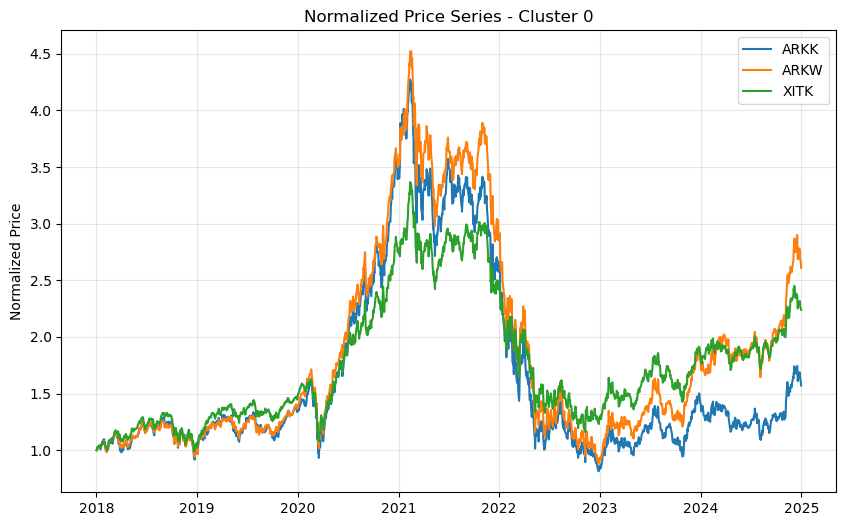


Cluster 1:
Number of ETFs: 2
Tickers: ITEQ, XSW


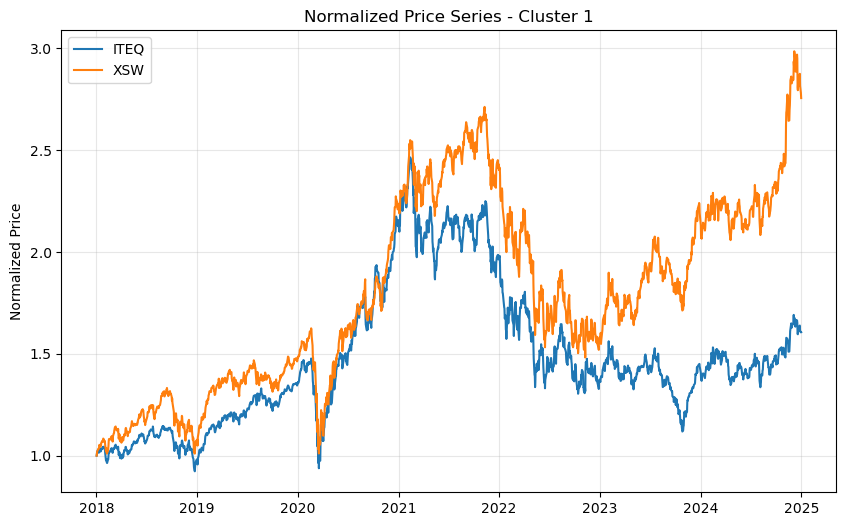


Cluster 2:
Number of ETFs: 2
Tickers: CIBR, HACK


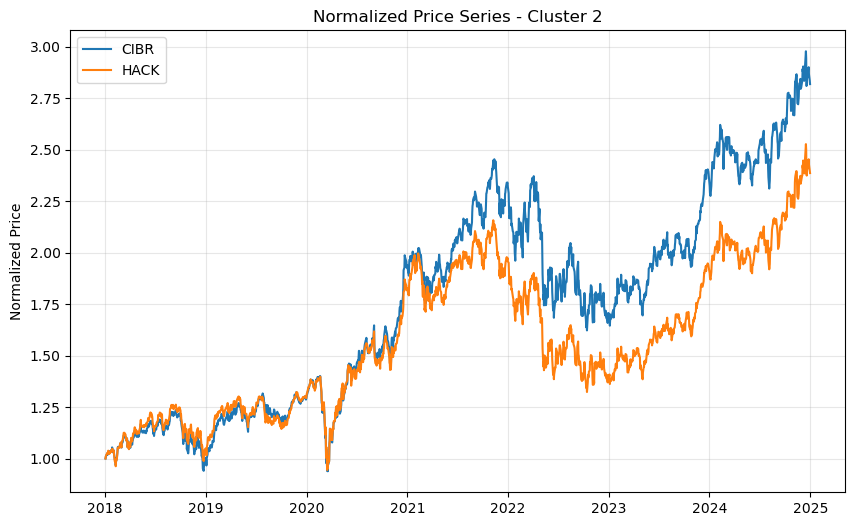


Cluster 3:
Number of ETFs: 3
Tickers: FDN, IGV, SKYY


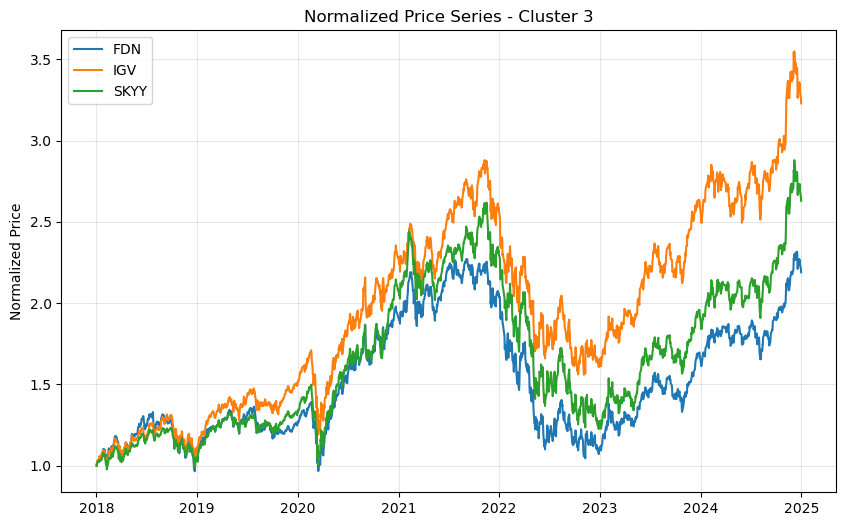


Cluster 4:
Number of ETFs: 3
Tickers: DTEC, ISRA, NUMG


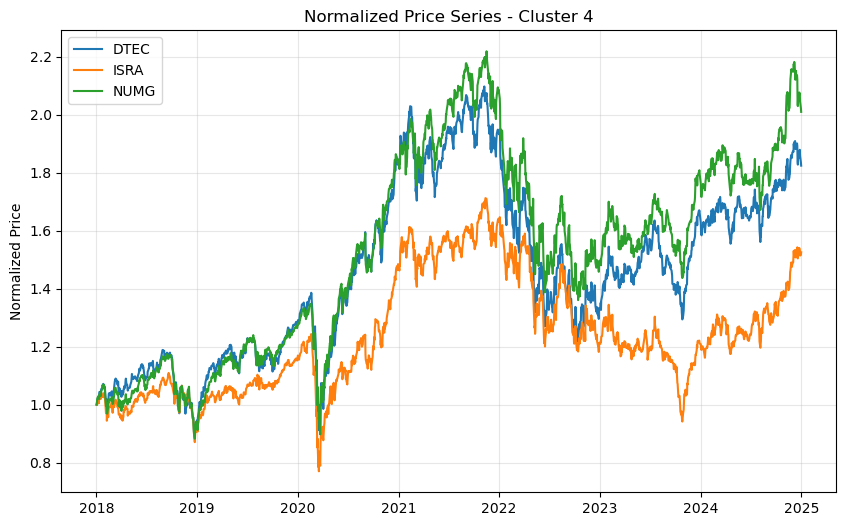


Cluster 5:
Number of ETFs: 2
Tickers: FYC, PRNT


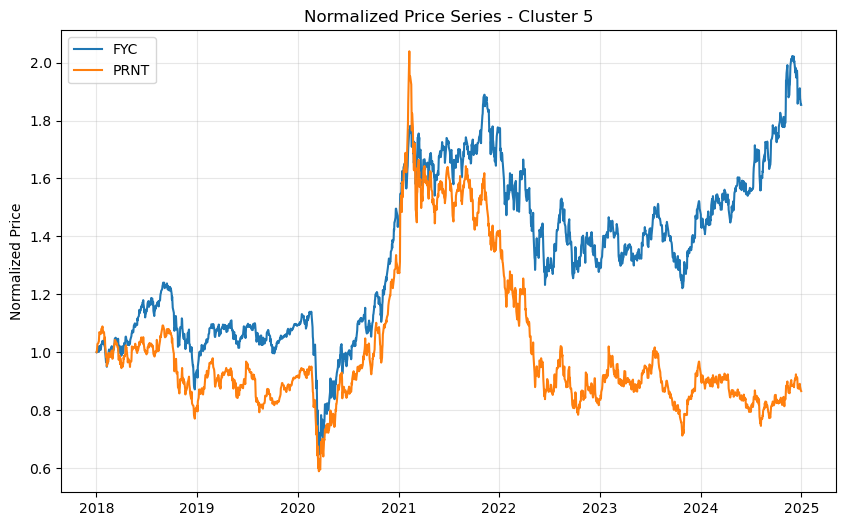


Cluster 6:
Number of ETFs: 2
Tickers: IPAY, QQXT


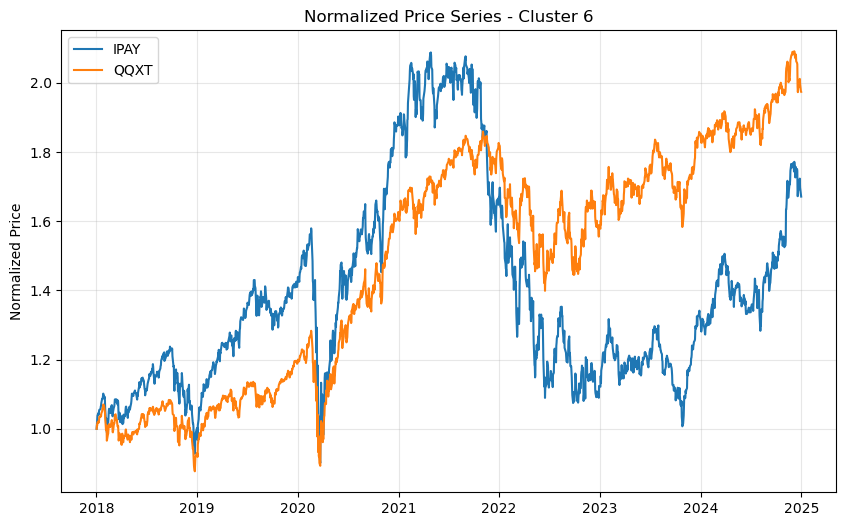


Cluster 7:
Number of ETFs: 3
Tickers: LRGE, MTUM, NULG


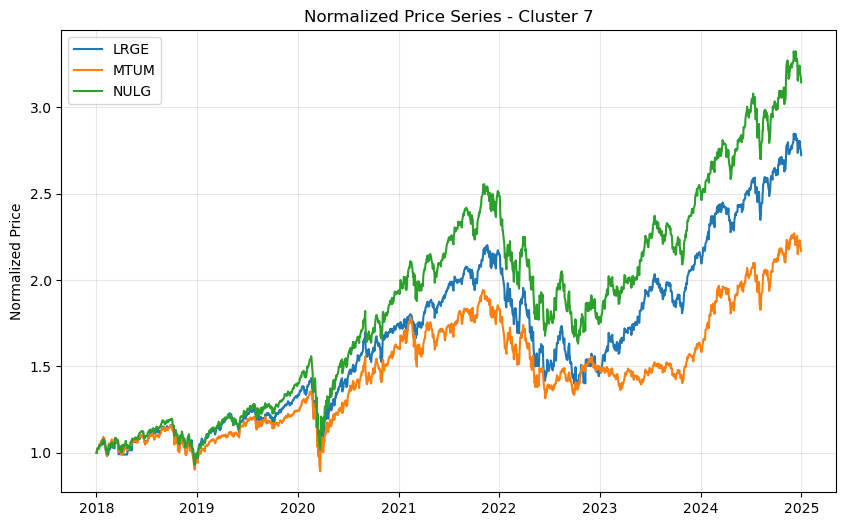


Cluster 8:
Number of ETFs: 3
Tickers: IGM, QQQ, TQQQ


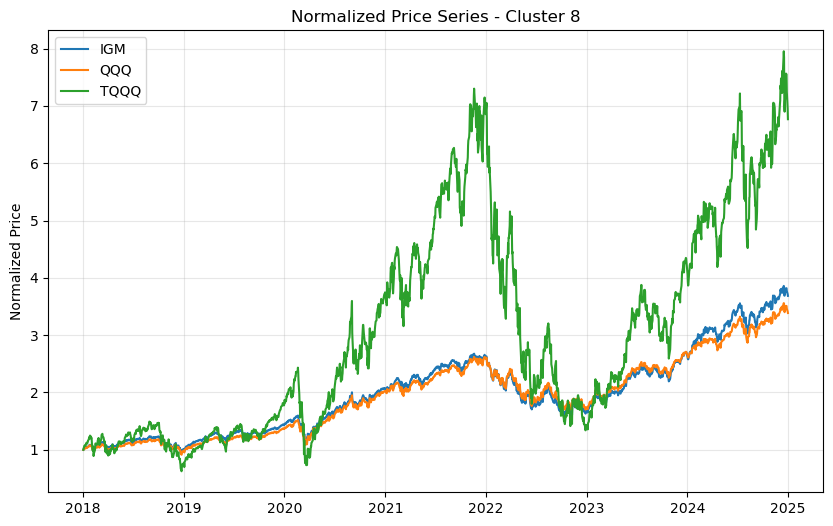


Cluster 9:
Number of ETFs: 2
Tickers: IYW, ROM


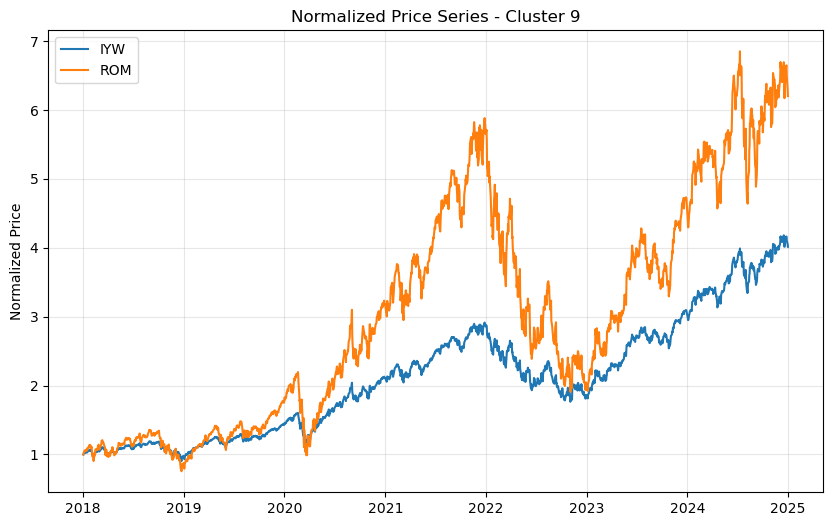


Cluster 10:
Number of ETFs: 2
Tickers: FTEC, VGT


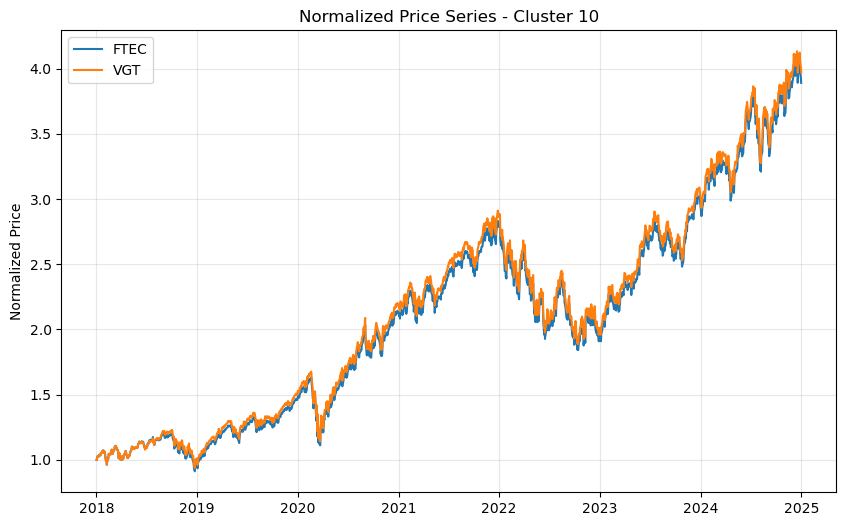


Cluster 11:
Number of ETFs: 3
Tickers: IXN, TECL, XLK


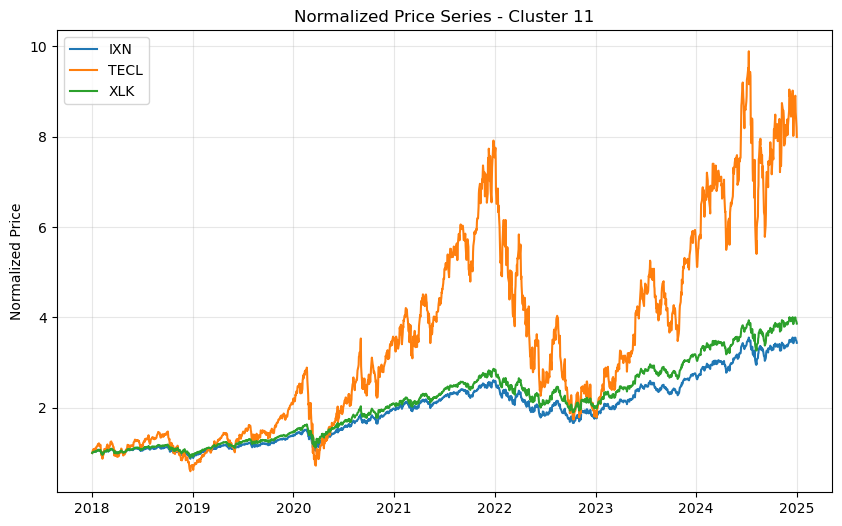


Cluster 12:
Number of ETFs: 3
Tickers: QQEW, QQQE, XT


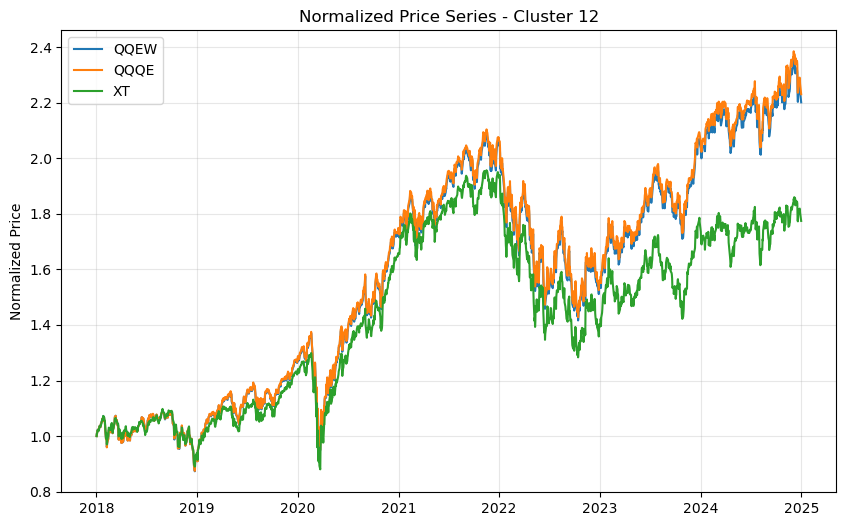


Cluster 13:
Number of ETFs: 2
Tickers: FXL, PTF


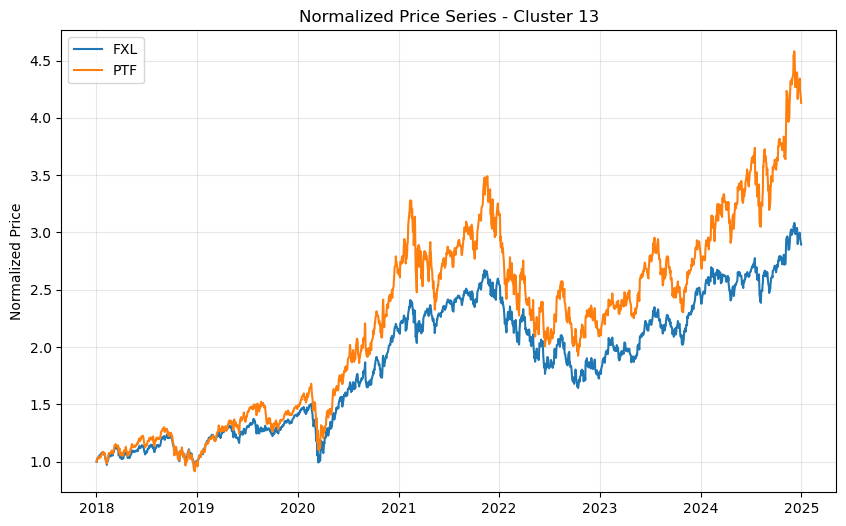


Cluster 14:
Number of ETFs: 2
Tickers: SUSA, VV


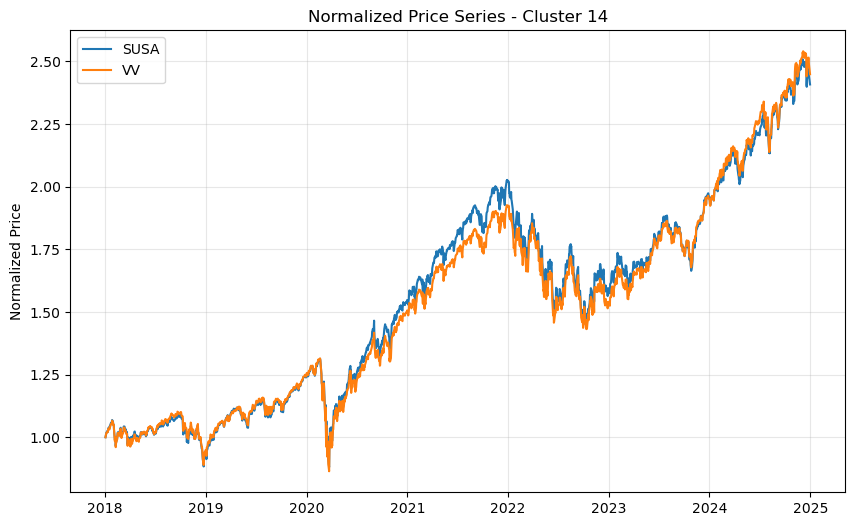


Cluster 15:
Number of ETFs: 2
Tickers: QTEC, XNTK


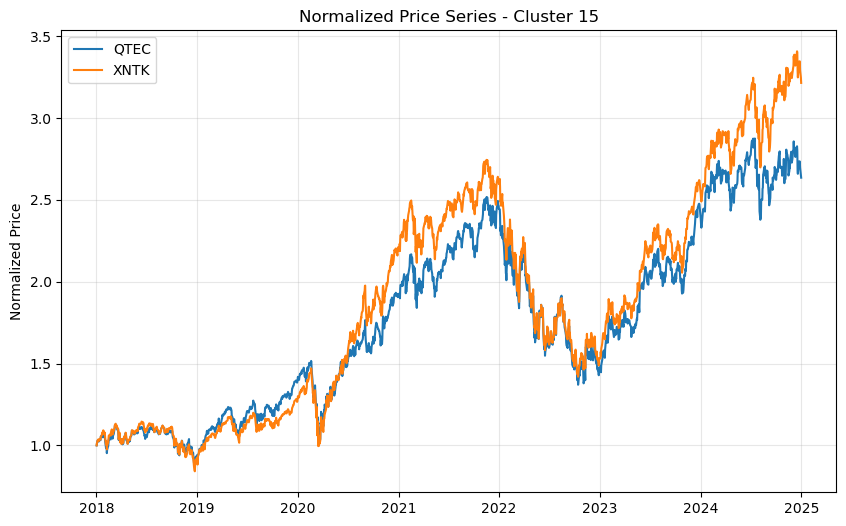


Cluster 16:
Number of ETFs: 3
Tickers: NXTG, PSCT, SNSR


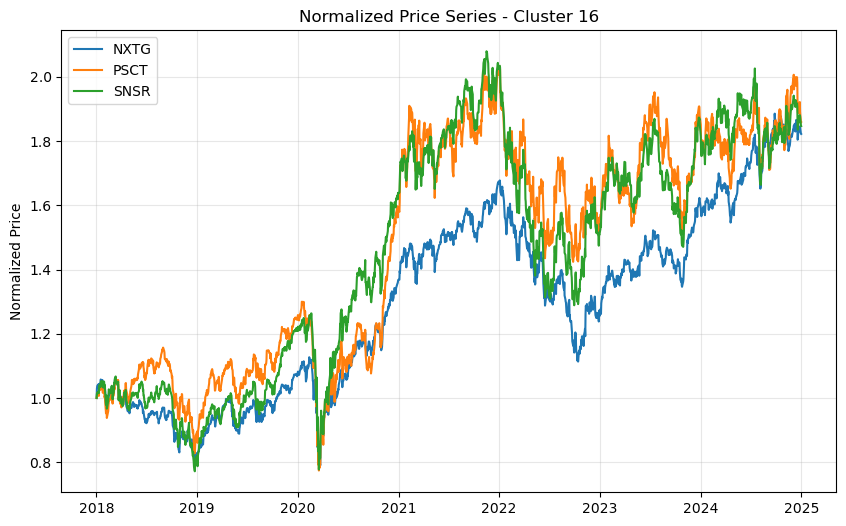


Cluster 17:
Number of ETFs: 5
Tickers: IDLV, IDMO, IEFA, PIZ, TLTD


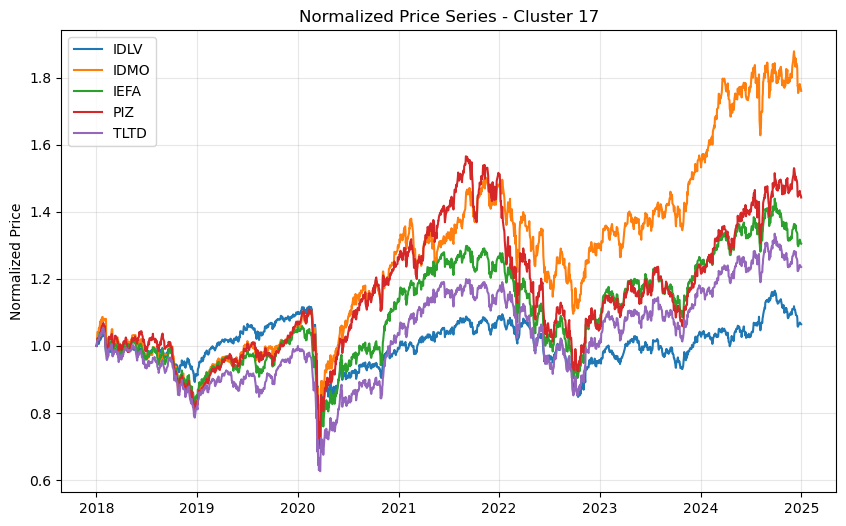


Cluster 18:
Number of ETFs: 3
Tickers: SMH, SOXL, SOXX


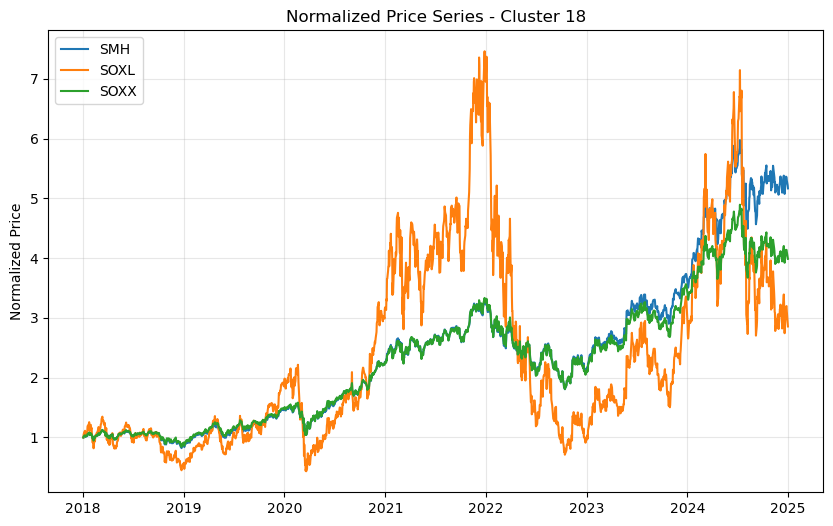


Cluster 19:
Number of ETFs: 3
Tickers: FTXL, PSI, XSD


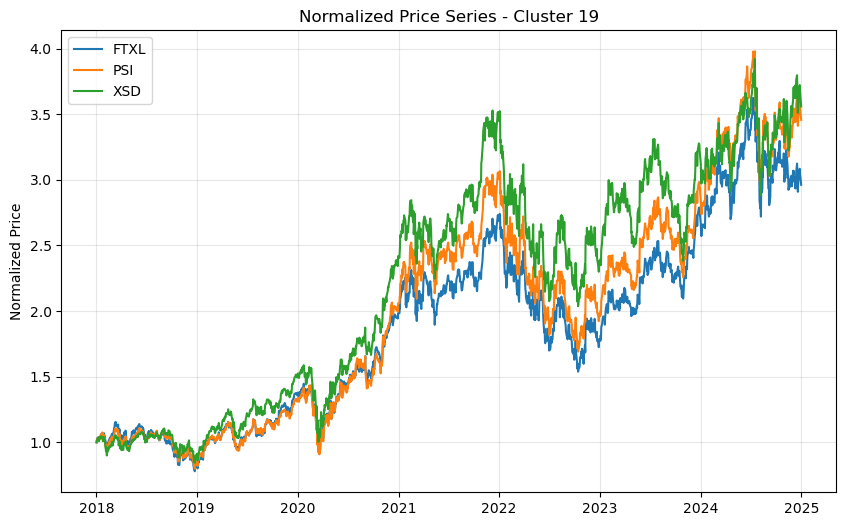


Cluster 20:
Number of ETFs: 6
Tickers: CQQQ, CWEB, FXI, KEMQ, KGRN, KWEB


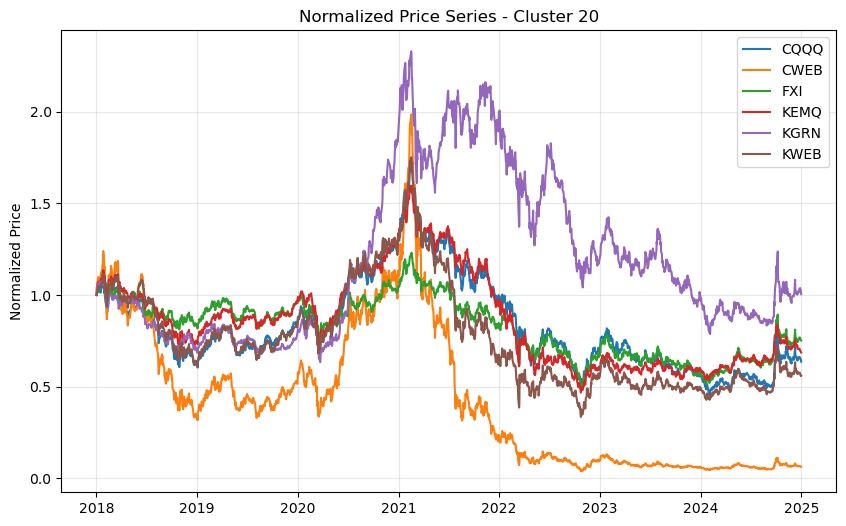


Cluster 21:
Number of ETFs: 2
Tickers: IDX, PIN


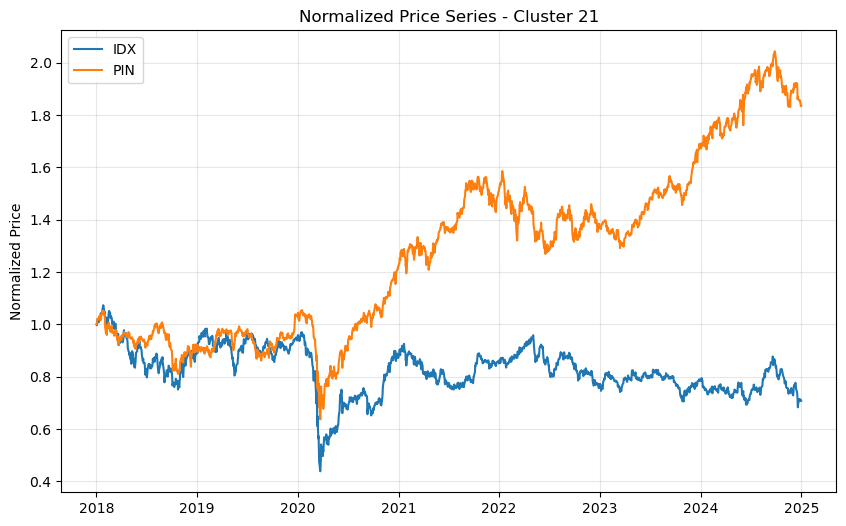


Cluster 22:
Number of ETFs: 4
Tickers: FXP, REW, SOXS, TECS


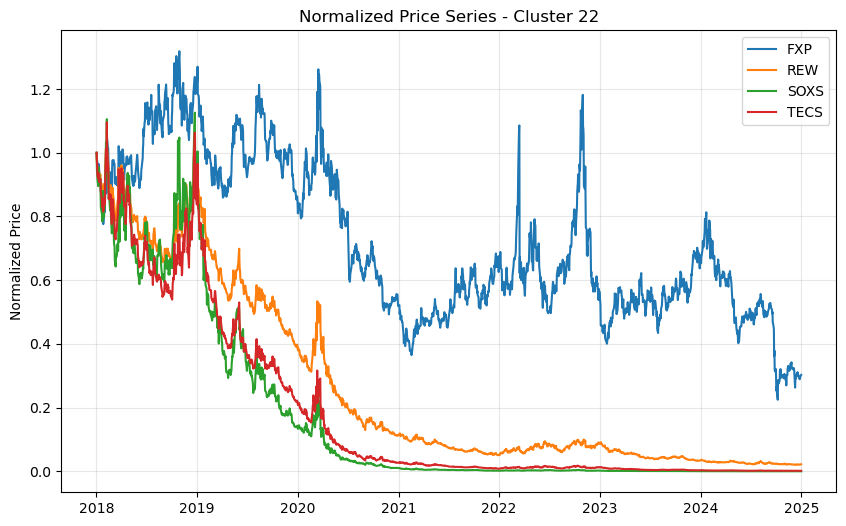

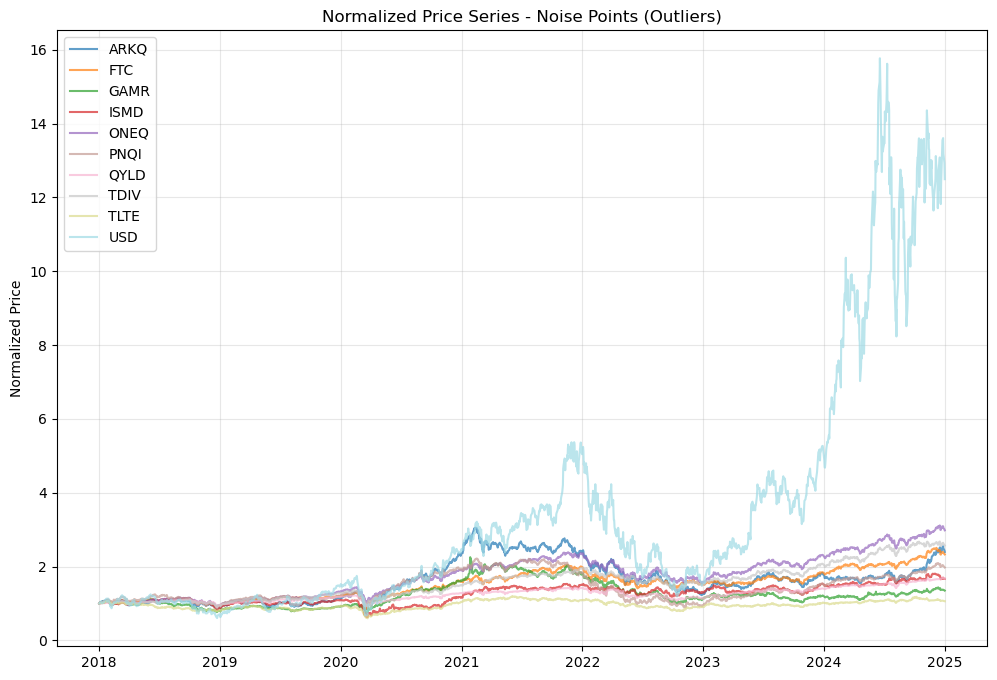


--- Cluster Summary Statistics ---

Total ETFs: 75
Number of clusters: 23
Number of noise points: 10

Cluster Performance Statistics:
 cluster_id  size  avg_return  volatility  sharpe
         -1    10       17.17       25.23    0.68
          0     3       18.20       37.90    0.48
          1     2       14.12       25.63    0.55
          2     2       16.61       24.07    0.69
          3     3       17.87       27.42    0.65
          4     3       10.82       21.78    0.50
          5     2        7.23       26.40    0.27
          6     2       11.34       22.35    0.51
          7     3       16.41       21.21    0.77
          8     3       31.95       40.47    0.79
          9     2       31.94       39.92    0.80
         10     2       23.06       26.20    0.88
         11     3       34.58       42.96    0.81
         12     3       12.81       21.97    0.58
         13     2       22.45       29.76    0.75
         14     2       14.69       19.77    0.74
         15    

In [38]:
# After the t-SNE visualization code, add this section to analyze clusters

print("\n\n--- Analyzing Clusters with Optimized Parameters ---\n")

# Analyze clusters including noise points
noise_points = []

for cluster_id in sorted(set(cluster_labels)):
    # Get tickers in this cluster
    mask = cluster_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    
    if cluster_id == -1:
        noise_points = list(tickers_in_cluster)
        print(f"\nNoise Points (Outliers):")
        print(f"Number of ETFs: {len(tickers_in_cluster)}")
        print(f"Tickers: {', '.join(tickers_in_cluster)}")
        continue
        
    print(f"\nCluster {cluster_id}:")
    print(f"Number of ETFs: {len(tickers_in_cluster)}")
    print(f"Tickers: {', '.join(tickers_in_cluster)}")
    
    # Plot the normalized price series for this cluster
    plt.figure(figsize=(10, 6))
    for ticker in tickers_in_cluster:
        # Normalize to start at 1
        normalized_prices = close_prices[ticker] / close_prices[ticker].iloc[0]
        plt.plot(normalized_prices, label=ticker)
    
    plt.title(f'Normalized Price Series - Cluster {cluster_id}')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'optimized_cluster_{cluster_id}_prices.png', dpi=300, bbox_inches='tight')
    plt.show()

# If there are noise points, plot them too
if noise_points:
    # Plot the normalized price series for noise points
    plt.figure(figsize=(12, 8))
    
    # Use a different color for each noise point
    colors = plt.cm.tab20(np.linspace(0, 1, len(noise_points)))
    
    for i, ticker in enumerate(noise_points):
        # Normalize to start at 1
        normalized_prices = close_prices[ticker] / close_prices[ticker].iloc[0]
        plt.plot(normalized_prices, label=ticker, color=colors[i], alpha=0.7)
    
    plt.title('Normalized Price Series - Noise Points (Outliers)')
    plt.ylabel('Normalized Price')
    
    # Create a more readable legend if there are many noise points
    if len(noise_points) > 15:
        # Split the legend into multiple columns
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                  ncol=5, fontsize=8)
    else:
        plt.legend(loc='best')
        
    plt.grid(True, alpha=0.3)
    plt.savefig('noise_points_prices.png', dpi=300, bbox_inches='tight')
    plt.show()

# Calculate and display summary statistics for each cluster
print("\n--- Cluster Summary Statistics ---\n")
print(f"Total ETFs: {len(close_prices.columns)}")
print(f"Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(f"Number of noise points: {list(cluster_labels).count(-1)}")

# Calculate average returns and volatility for each cluster
cluster_stats = []

for cluster_id in sorted(set(cluster_labels)):
    mask = cluster_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    
    if len(tickers_in_cluster) == 0:
        continue
        
    # Calculate average return for the cluster
    cluster_returns = returns[tickers_in_cluster].mean(axis=1)
    avg_return = cluster_returns.mean() * 252 * 100  # Annualized percentage
    
    # Calculate volatility for the cluster
    volatility = cluster_returns.std() * np.sqrt(252) * 100  # Annualized percentage
    
    # Calculate Sharpe ratio (assuming risk-free rate of 0 for simplicity)
    sharpe = avg_return / volatility if volatility > 0 else 0
    
    cluster_stats.append({
        'cluster_id': cluster_id,
        'size': len(tickers_in_cluster),
        'avg_return': avg_return,
        'volatility': volatility,
        'sharpe': sharpe
    })

# Convert to dataframe and display
stats_df = pd.DataFrame(cluster_stats)
if not stats_df.empty:
    stats_df = stats_df.sort_values('cluster_id')
    print("\nCluster Performance Statistics:")
    print(stats_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))